In [1]:
import tskit
import numpy as np
import matplotlib.pyplot as plt
import pyproj
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'
import glob
import re
import tsconvert
import time

The purpose here is to see if our trees are similar to previous estimates and our dispersal estimates are sane.

# coalescence and mutation rates

let's first look at the effective population sizes inferred by relate, to see if our tree sequences are reasonable

In [2]:
def get_epochs(coalfile):
    """Get epochs and population sizes in each from coal file (produced by Relate).

    Parameters:
        coalfile (string): Name of .coal file.

    Returns:
        epochs (numpy array): Start and end times of each epoch.
        Nes (np array): Effective population sizes in each epoch (with last entry repeated).
    """

    epochs = np.genfromtxt(coalfile,skip_header=1,skip_footer=1) #time at which each epoch starts (and the final one ends)
    Nes = 0.5/np.genfromtxt(coalfile,skip_header=2)[2:-1] #effective population size during each epoch (note that the coalescent rate becomes 0 after all trees have coalesced, and so Ne goes to infinity)
    Nes = np.array(list(Nes)+[Nes[-1]]) #add the final size once more to make same length as epochs

    return epochs, Nes

In [3]:
basename = '../data/T2T_Athaliana_66.Chr%d.nomissing.nohet.justSNPs_haploid_polarized_masked_%dNe_%sm_popsize_%dnumiter_%.1fthreshold'
Ne = 1e5 #prior Ne
m = '7e-9' #prior mutation rate
numiter = 10 #number of MCMC iterations in estimating Ne
threshold = 0.5 #fraction of trees to drop when estimating Ne
nsamples = 1000 #number of trees per locus

In [4]:
coalfile=basename%(1,Ne,m,numiter,threshold) + '.coal'
epochs = np.genfromtxt(coalfile, skip_header=1, skip_footer=1)
Nes = 0.5/np.genfromtxt(coalfile, skip_header=2)[2:]

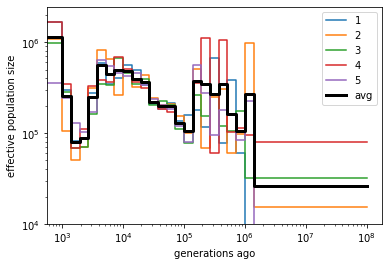

In [5]:
chrs = range(1,6)

fig, ax = plt.subplots()

for i,chr in enumerate(chrs):
    coalfile=basename+'.coal'
    epochs, Nes = get_epochs(coalfile%(chr,Ne,m,numiter,threshold))
    ax.step(epochs, Nes, label=chr)
    if i==0:
        all_Nes = Nes
    else:
        all_Nes += Nes
all_Nes = all_Nes/len(chrs)
ax.step(epochs, all_Nes, label='avg', color='k', linewidth=3)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('generations ago')
ax.set_ylabel('effective population size')
ax.legend()
ax.set_ylim(ymin=1e4)
    
plt.show()

this treats all samples as part of one big "population", which is a bit hard to interpret with so much structure. so let's next look at the cross-coalescence rates for each pair of PCA groups.

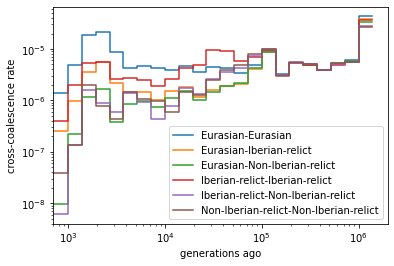

In [6]:
chrs = range(1,6)

pops = ['Eurasian', 'Iberian-relict', 'Non-Iberian-relict']
pop_pairs = [i+'-'+j for i in pops for j in pops]
not_duplicate = [i<=j for i in range(len(pops)) for j in range(len(pops))]

for i,chr in enumerate(chrs):
    coalfile=basename+'.pairwise.coal'
    data = np.genfromtxt(coalfile%(chr,Ne,m,numiter,threshold),skip_header=2)[:,2:]
    if i==0:
        all_pairwise_Nes = data
    else:
        all_pairwise_Nes += data
all_pairwise_Nes = all_pairwise_Nes/len(chrs)

fig, ax = plt.subplots()
        
for i,pairwise_Ne in enumerate(all_pairwise_Nes):
    if not_duplicate[i]:
        ax.step(epochs, pairwise_Ne, label=pop_pairs[i])
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('generations ago')
ax.set_ylabel('cross-coalescence rate')
ax.legend()
# ax.set_ylim(ymin=1e4)
    
plt.show()

we can compare this (excluding non-Iberian relicts) with fig4A in 1001g: https://www.sciencedirect.com/science/article/pii/S0092867416306675?via%3Dihub, and the patterns are pretty similar, though I have no idea what their y-axis scale is (they say it is coalescence rate but the numbers are >>1).

we can also compare to the newer analysis of Durvasula et al, fig 5: https://doi.org/10.1073/pnas.161673611. In this case it helps to flip back to thinking about effective population sizes, and reverse the time axis

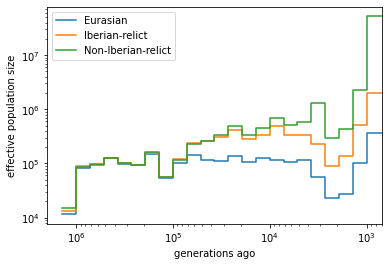

In [7]:
fig, ax = plt.subplots()
        
for i,pairwise_Ne in enumerate(all_pairwise_Nes[::3]):
    ax.step(epochs, 0.5/pairwise_Ne, label=pops[i])
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('generations ago')
ax.set_ylabel('effective population size')
ax.legend()
# ax.set_ylim(ymin=1e4)
ax.invert_xaxis()
    
plt.show()

this looks quite different. they see Ne decline from 1e5 to 1e4 as we approach the present. not sure where the difference comes in, but note they have 1500 samples, while we have 66.

and let's also look at the estimated mutation rate:

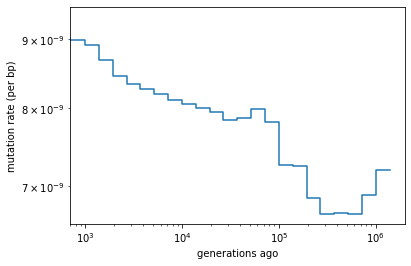

In [8]:
chrs = range(1,6)

for i,chr in enumerate(chrs):
    ratefile=basename+'_avg.rate'
    data = np.genfromtxt(ratefile%(chr,Ne,m,numiter,threshold))[:,1]
    if i==0:
        mutrates = data
    else:
        mutrates += data
mutrates = mutrates/len(chrs)        

fig, ax = plt.subplots()

ax.step(epochs, mutrates)
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('generations ago')
ax.set_ylabel('mutation rate (per bp)')
# ax.legend()
# ax.set_ylim(ymin=1e4)
    
plt.show()

we used the typical prior of 7e-9, but it looks like Relate wanted a larger mutation rate in recent time (though not too much higher). that would be to have things coalesce quickly (according to Ne) but still be diverged enough. 

the relate docs say that the mutation rate is conflated with the coalescence rate. presumably the product of the two (theta) is what can be estimated?

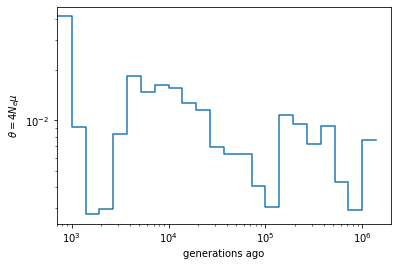

In [9]:
fig, ax = plt.subplots()

ax.step(epochs, 4 * all_Nes * mutrates)
# ax.plot(epochs, [4*2e5*7e-9 for _ in epochs])
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('generations ago')
ax.set_ylabel(r'$\theta = 4 N_e \mu$')
# ax.legend()
# ax.set_ylim(ymin=1e4)
    
plt.show()

# mutations vs branch lengths

The first thing we want to do is, using genetic data alone (no trees), get the genetic distances between our samples.

To do this, load the tree sequences for each chromosome

In [10]:
filename = basename + '.trees'
tss = []
for i in range(5):
    tss.append(tskit.load(filename %(i+1,Ne,m,numiter,threshold)))

Get genetic distances between all pairs of samples

In [11]:
k = tss[0].num_samples

sample_sets = [[i] for i in range(k)]
indexes = [(i,j) for i in range(k) for j in range(i,k)] #upper triangle only

pis = np.zeros(len(indexes))
for ts in tss:

    # get genetic distances between all pairs of (haploid) samples at each chromosome
    pis += ts.divergence(sample_sets=sample_sets, indexes=indexes, mode='site', windows=None)

pis = pis/len(tss) #average over chromosomes

Plot the distribution

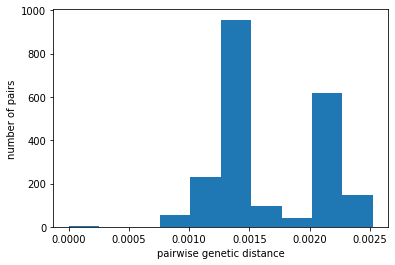

In [12]:
plt.hist(pis)
plt.xlabel('pairwise genetic distance')
plt.ylabel('number of pairs')
plt.show()

These distances are about half of what is observed in the 1001g dataset, fig3A: https://www.sciencedirect.com/science/article/pii/S0092867416306675?via%3Dihub). Likely due to filtering and masking?


Next let's compare these genetic distances with the expected distances we get from our inferred branch lengths (averaged over all trees in the genome), to make sure our branch lengths make sense.

In [13]:
n = 2 #every nth pair, for memory
epis = np.zeros(len(indexes[::n])) 
for i,ts in enumerate(tss):
    print('chromosome %d'%i)
    epis += ts.divergence(sample_sets=sample_sets, indexes=indexes[::n], mode='branch', windows=None)
epis = epis/len(tss) #average over chromosomes

chromosome 0
chromosome 1
chromosome 2
chromosome 3
chromosome 4


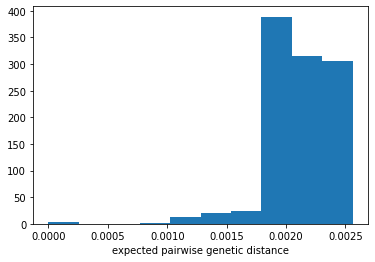

In [14]:
plt.hist(epis*7e-9)
plt.xlabel('expected pairwise genetic distance')
plt.show()

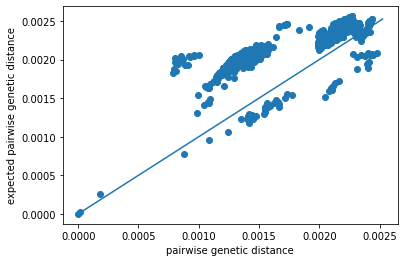

In [15]:
plt.scatter(pis[::n],epis*7e-9) #multiply by mutation rate to get expected number of mutations per site
plt.plot([0,np.nanmax(pis)],[0,np.nanmax(pis)]) #1 to 1 line
plt.xlabel('pairwise genetic distance')
plt.ylabel('expected pairwise genetic distance')
plt.show()

this seems pretty decent as we do expect some variance from the mutational process. 

would be nice to split this by group, so load metadata

In [16]:
ids = []
ids_file='../data/T2T_Athaliana_66.Chr%d.nomissing.nohet.justSNPs_haploid.samples' %1
with open(ids_file, mode='r') as file:
    next(file); next(file) #skip header and 0 row
    for line in file: 
        ids.append(line.strip().split(' ')[0])

metadata = []
with open('../data/66_genomes_summary.txt','r') as file:
    next(file) #skip header
    for line in file:
        metadata.append(line.strip().split('\t'))
        
accessions = [i[1].strip().replace('_','.').split('.')[0].replace('"','') for i in metadata]
accessions2 = [i[3] for i in metadata]

order = []
for id in ids:
    try:
        ix = accessions.index(id)
    except:
        ix = accessions2.index(id)
    order.append(ix)

group = np.array([i[2] for i in metadata])[order]
population_names, population_ixs = np.unique(group, return_inverse=True)

our "groups" are

In [17]:
population_names

array(['Eurasian', 'Iberian relict', 'Non-Iberian relict'], dtype='<U18')

and for each pairwise comparison the pair of groups are

In [18]:
pop_ix_pairs = [sorted([population_ixs[j] for j in i]) for i in indexes]

choose colors for plot

In [19]:
colors = []
for i in pop_ix_pairs:
    if i == [0,0]:
        colors.append('blue') #eurasian
    elif i == [1,1]:
        colors.append('green') #iberian relict
    elif i == [2,2]:
        colors.append('red') #non-iberian relict
    elif i == [0,1]:
        colors.append('brown') #eurasian - iberian relict
    elif i == [0,2]:
        colors.append('orange')#eurasian - non-iberian relict
    elif i == [1,2]:
        colors.append('yellow') #iberian relict - non-iberian relict

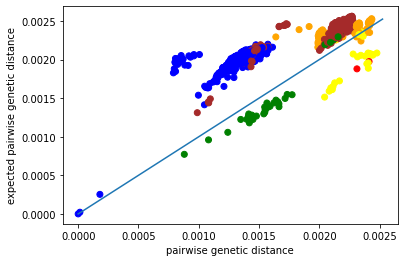

In [20]:
plt.scatter(pis[::n],epis*7e-9,c=colors[::n]) #multiply by mutation rate to get expected number of mutations per site
plt.plot([0,np.nanmax(pis)],[0,np.nanmax(pis)]) #1 to 1 line
plt.xlabel('pairwise genetic distance')
plt.ylabel('expected pairwise genetic distance')
plt.show()

so some things make good sense here, eg the genetic distances between eurasian and iberian relict groups are greater than within each group. the thing i'm most curious about is why the branch lengths are too long especially within the eurasian group, but let's just say things look reasonable for now.

# genetic vs geographic distance

let's now bring in geographic distance

order locations to align with tree sequence

In [21]:
locations = np.array([list(map(float,[i[7].replace(',','.'),i[6].replace(',','.')])) for i in metadata])[order]

and plot

In [22]:
px.scatter_geo(lon=locations[:,0],lat=locations[:,1], color=group, hover_name=ids)

now calculate pairwise distances

In [23]:
g = pyproj.Geod(ellps='clrk66') # Use Clarke 1866 ellipsoid.

geods = []
for i in indexes:
    geod = g.inv(locations[i[0]][0],locations[i[0]][1],
                 locations[i[1]][0],locations[i[1]][1])[2]/1000 #great circle distance
    geods.append(geod)

and plot genetic distance against geographic distance

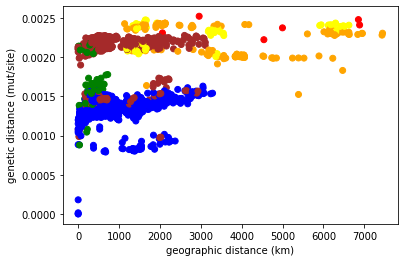

In [24]:
plt.scatter(geods, pis, c=colors)
plt.ylabel('genetic distance (mut/site)')
plt.xlabel('geographic distance (km)')
plt.show()

and the same for expected genetic distance vs geographic distance

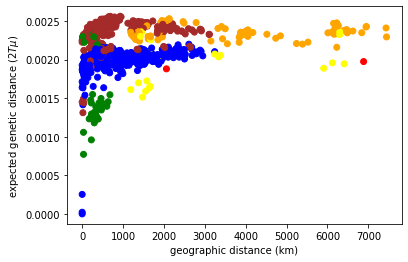

In [25]:
plt.scatter(geods[::n], (epis*7e-9), c=colors[::n])
plt.ylabel('expected genetic distance ($2T\mu$)')
plt.xlabel('geographic distance (km)')
# plt.xscale('log')
# plt.xlim(xmin=1e1)
plt.show()

good, these roughly match fig3D in https://www.sciencedirect.com/science/article/pii/S0092867416306675#fig3

now, what kind of dispersal rates make sense given the data, on a coarse level?

we can do this based on the pairwise distances. assuming independent Brownian motion in each of 2 dimensions, the distances are distributed like a Rayleigh (https://en.wikipedia.org/wiki/Rayleigh_distribution), with mean $\sqrt{\pi\sigma^2T_{mrca}}$ and variance $(4-\pi)\sigma^2T_{mrca}$.

the mle dispersal estimate from the pairwise distances is the average squared geographic distance over time

In [26]:
sigma2 = np.nanmean([i**2 for i in geods[::n]]/epis) #guess at sigma^2 (mle?)
sigma2

9.170064671606248

to see how well the Brownian motion model and mle of $\sigma^2$ fit the data, let's plot the observed - expected distances against the sqrt of time apart, and also plot $\pm2$ standard deviations (not sure what the exact interval should be, eg to capture 95% of the data, but it would be something like this).

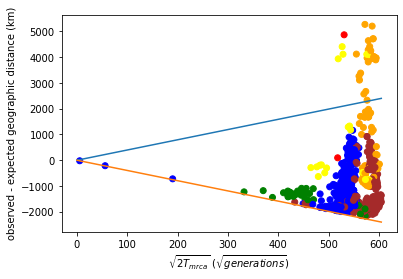

In [27]:
plt.scatter(epis**0.5, geods[::n] - (np.pi*sigma2*epis/2)**0.5, c=colors[::n])
plt.xlabel('$\sqrt{2T_{mrca}}$ ($\sqrt{generations}$)')
plt.ylabel('observed - expected geographic distance (km)')
times = np.linspace(0,np.nanmax(epis),1000)
plt.plot(times**0.5, 2*((4-np.pi)*sigma2*times/2)**0.5)
plt.plot(times**0.5, -2*((4-np.pi)*sigma2*times/2)**0.5)
# plt.xscale('log')
# plt.xlim(xmin=1e1)
plt.show()

this is very nice. and if we use the observed genetic distances as an estimate of time

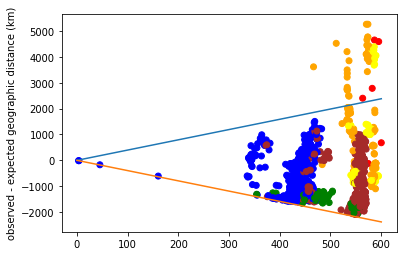

In [28]:
etimes = pis/7e-9 #estimated 2TMRCAs
etime = np.linspace(0,np.nanmax(etimes),1000)
plt.scatter(etimes**0.5, geods - (np.pi*sigma2*etimes/2)**0.5, c=colors)
plt.xlabel('')
plt.ylabel('observed - expected geographic distance (km)')
plt.plot(etime**0.5, 2*((4-np.pi)*sigma2*etime/2)**0.5)
plt.plot(etime**0.5, -2*((4-np.pi)*sigma2*etime/2)**0.5)
# plt.xscale('log')
# plt.xlim(xmin=1e1)
plt.show()

again, pretty sensible

if we want more precise confidence intervals, just look at the observed distances, and 95% of them should be less than $\sqrt{4\sigma^2 T_{mrca} \log(20)}$

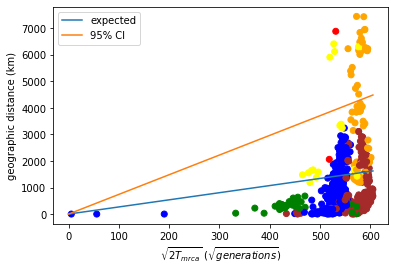

In [29]:
plt.scatter(epis**0.5, geods[::n], c=colors[::n])
plt.xlabel('$\sqrt{2T_{mrca}}$ ($\sqrt{generations}$)')
plt.ylabel('geographic distance (km)')
plt.plot(times**0.5, (np.pi*sigma2*times/4)**0.5, label='expected') #expected distance
plt.plot(times**0.5, (2*sigma2*times*np.log(20))**0.5, label='95% CI') #95% of distances should be less than this
# plt.xscale('log')
# plt.xlim(xmin=1e1)
plt.legend()
plt.show()

this doesn't look too bad, we're just missing lots of short times and have some outliers (esp when comparing eurasian and non-Iberian relicts, in orange, which have moved much further than expected, suggesting fast long-range dispersal)

# chromosomes vs trees

so what we have above, at the genome level, looks ok. but what happens when we look at tree-by-tree divergence, rather than genome-wide divergence? 

let's investigate using a single chromosome

In [30]:
n = 1 #just use everth nth pair, to speed up
CHR = 4 #choose chromosome
ts = tss[CHR-1] 

if we estimate dispersal by averaging divergence across trees (as above, but now with just 1 chromosome) we get

In [31]:
epis = ts.divergence(sample_sets=sample_sets, indexes=indexes[::n], mode='branch', windows=None)
sigma2_avg = np.nanmean([i**2 for i in geods[::n]]/epis)
sigma2_avg

9.55073710969993

if we instead calculate divergence at every tree

In [32]:
epis_trees = ts.divergence(sample_sets=sample_sets, indexes=indexes[::n], mode='branch', windows='trees')

and plot the dispersal estimates across the chromosome

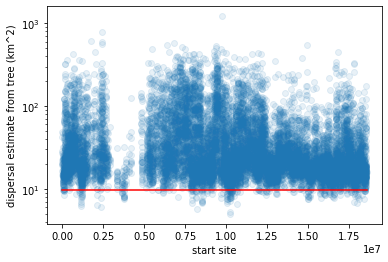

In [33]:
xs = [i for i in tss[3].breakpoints()][:-1]
ys = [np.nanmean([i**2 for i in geods[::n]]/es) for es in epis_trees]
plt.scatter(xs, ys, alpha=0.1)
plt.plot([0,max(xs)],[sigma2_avg,sigma2_avg], c='r')
plt.yscale('log')
plt.xlabel('start site')
plt.ylabel('dispersal estimate from tree (km^2)')
plt.show()

we see that the tree-by-tree estimates are often much higher than the chromosome-wide estimate.

i guess this is likely because in any one tree the branches connecting two somewhat distant samples might be too short (due to lack of info, or by error), causing high dispersal rates, but when averaging out the branch lengths over the whole chromosome these two samples are appropriately distant (ie, we can get the chromosome-wide average relatedness correct, but there is a lot of noise/error in tree-by-tree relatedness)

this makes me worried about inferring dispersal from trees with little information. let's see how many mutations we have per tree, and how that relates to the dispersal estimate

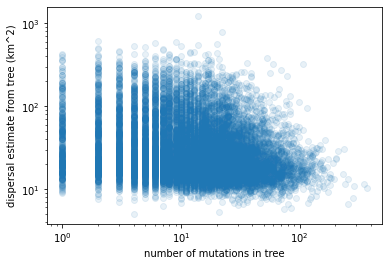

In [34]:
xs = [tree.num_mutations for tree in ts.trees()]
plt.scatter(xs, ys, alpha=0.1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of mutations in tree')
plt.ylabel('dispersal estimate from tree (km^2)')
plt.show()

it looks like both the mean and variance in dispersal rate decline with the number of mutations in a tree. this variance looks like it could have a particularly large effect, eg if we pick lots of less informative trees with (by chance/error) very high dispersal rates.

we should do some reading on exactly how Relate samples branch lengths, as i dont think this relies just on mutations in a tree, but rather on mutations that fall on each branch (and branches are shared across trees).

- in the initial tree build, Relate uses all mutations that fall on a branch to estimate the branch length (under a Poisson model with constant population size), thereby using more mutations than held in a single tree. 

- in the estimatePopSize follow-up, Relate does the same thing, but just estimates coalescent rates and branch lengths iteratively for trees with the most mutations (an option that defaults to 1/2 the trees). all branches are updated under a piecewise constant population size in a final step.

- the last thing to work out is how Relate samples branch lengths. not clear from the paper, but from the website it sounds as if the same process is used -- map mutations (across trees) to branches, estimate lengths. could ask Leo to double check, but seems crazy if not like the method above.

i guess then, that the while the number of mutations per tree is not completely indicative of the number of mutations per branch in a tree, that there must still be some correlation, so that trees with more mutations have branch lengths with less uncertainty (leading to less variance in dispersal estimates above).

one reason why the mean dispersal estaimte may decline with number of mutations in the tree is that, as Graham pointed out, more mutations might be the result of a larger tree span, which means the times must be shorter to avoid recombining first. so another reason to disregard the above. what could be helpful to see instead is the branch length between pairs of samples vs the number of mutations/site between samples on a tree by tree level (but note this is still not the exact right think because relate uses mutations outside of trees).

In [35]:
pis_trees = ts.divergence(sample_sets=sample_sets, indexes=indexes[::n], mode='site', windows='trees')

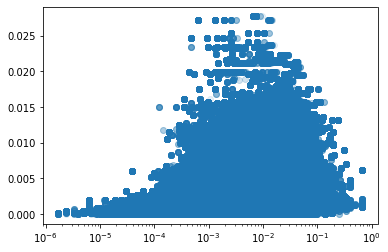

In [36]:
plt.scatter(pis_trees, epis_trees*7e-9, alpha=0.1)
plt.xscale('log')
# plt.yscale('log')
plt.show()

not really sure what to make of this since the branch lengths depend on mutations outside the trees.

for reference, our mutation rate is about 7e-9 and our recombination rate is about

In [37]:
cM_Mb = np.mean(np.loadtxt('../data/arab_chr%d_map_loess.map' %CHR)[:,2]) #avg cM per Mb on CHR
cM_b = cM_Mb * 1e-6 * 0.05 #cM per base, correct for outcrossing rate of 0.05
r_b = (1 - np.exp(-2*cM_b/100))/2 #prob of recombination between bases per gen
r_b

1.0135963735002917e-09

which matches stdpopsim roughly (8e-10), and most importantly is less than the mutation rate, which helps branch length inference (see fig 3 of https://academic.oup.com/genetics/article/221/1/iyac044/6554197)

another thing to try is, because dispersal depends on 1/t, we could take the harmonic mean divergence time between samples over trees

In [38]:
epis_harmonic = 1/np.nanmean(1/epis_trees,axis=0)
sigma2_avg_harmonic = np.nanmean([i**2 for i in geods[::n]]/epis_harmonic)
sigma2_avg_harmonic

/tmp/ipykernel_42256/3911509954.py:1: RuntimeWarning:

Mean of empty slice



43.072120650719185

and this is exactly the mean of the tree by tree estimates

In [39]:
np.mean([np.nanmean([i**2 for i in geods[::n]]/es) for es in epis_trees])

43.07212065071916

this reinforces the fact that short branch lengths will have a disproportionate effect on the dispersal rate.

we can replicate our cone plot, now using the times at every tree, and the new dispersal estimate

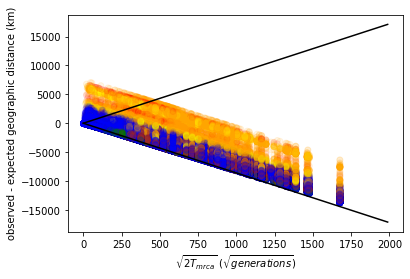

In [40]:
for es in epis_trees[::100]: #not using every tree, for speed
    plt.scatter(es**0.5, geods[::n] - (np.pi*sigma2_avg_harmonic*es/2)**0.5, c=colors[::n], alpha=0.1)

plt.xlabel('$\sqrt{2T_{mrca}}$ ($\sqrt{generations}$)')
plt.ylabel('observed - expected geographic distance (km)')

times = np.linspace(0,np.nanmax(epis_trees),1000)
plt.plot(times**0.5, 2*((4-np.pi)*sigma2_avg_harmonic*times/2)**0.5, c='k')
plt.plot(times**0.5, -2*((4-np.pi)*sigma2_avg_harmonic*times/2)**0.5, c='k')

# plt.xscale('log')
# plt.xlim(xmin=1e1)

plt.show()

so it looks like this model and dispersal estimate work well when the observed distance is smaller than expected (this must be where the dispersal estimate is coming from), but there are clearly many pairs of samples that have moved too far in too short a time|. 

# pairwise vs tree estimates

another potential issue is comparing these pairwise dispersal estimates to what we get when using the full tree structure. let's take this first tree as the example, with pairwise estimate given above. then the full tree estimate is

In [41]:
def shared_times(tree, samples, tCutoff=None):
    '''shared times between pairs of samples in tskit tree'''

    T = tree.time(tree.root) #tmrca
    k = len(samples)
    sts = np.zeros((k,k))
    for i in range(k):
        sts[i,i] = T #shared time with self
        for j in range(i):
            st = T - tree.tmrca(samples[i],samples[j]) #shared time of pair
            sts[i,j] = st
            sts[j,i] = st

    if tCutoff is None or tCutoff > T:
        return [sts], [samples] #return a single tree
            
    else:
        shared_time = tCutoff - (T-sts) #shared time since tCutoff

        # get shared times and samples in each subtrees
        sts = [] #start list with shared times in subtree with i
        smpls = [] #samples in this subtree
        taken = [False for _ in range(k)]
        while sum(taken) < k: #while some samples not yet in a subtree
            i = np.argmax(taken == False) #choose next sample not yet in a subtree
            withi = shared_time[i] >= 0 #true if shares time with i
            timesi = shared_time[withi][:, withi] #shared times of subtree with i
            timesi = timesi - np.min(timesi) #trim
            sts.append(timesi) #append        
            smpls.append(samples[np.where(withi)[0]]) #samples in this subtree
            taken = np.array([i[0] or i[1] for i in zip(taken, withi)]) #samples already in a subtree
            
        return sts, smpls #return list of shared times and samples in each subtree
    
def mle_dispersal_tree(locations, shared_times):
    """Maximum likelihood estimate of dispersal rate given locations and shared times between lineages.

    Parameters:
        locations (array-like): Locations. An n x d array, where n is the number of locations and d is the number of spatial dimensions.
        shared_time (array-like): Shared times between lineages. An n x n array, where n is the number of lineages (arranged in same order as locations). 
    
    Returns:
        Maximum likelihood dispersal rate as a d x d covariance matrix.
    """

    n = len(locations) #number of samples
    Tmat = np.identity(n) - [[1/n for _ in range(n)] for _ in range(n)]; Tmat = Tmat[:-1]; #matrix for mean centering, which drops last sample (because we lose a degree of freedom when mean centering)
    locs = np.matmul(Tmat, locations) #mean center locations 
    stimes = np.matmul(Tmat, np.matmul(shared_times, np.transpose(Tmat))) #mean center shared times
    Tinv = np.linalg.pinv(np.array(stimes)) #invert shared time matrix

    return np.matmul(np.matmul(np.transpose(locs), Tinv), locs) / (n - 1) #mle dispersal rate, corrected to be unbiased

def mles_to_km2(mle, meanlon):
    'convert long/lat variances to kilometers squared'
    return mle[0][0] * 110**2, mle[1][1] * (np.cos(meanlon * np.pi/180)*111)**2

In [42]:
meanlon = np.mean(locations,axis=0)[0]

draw the tree

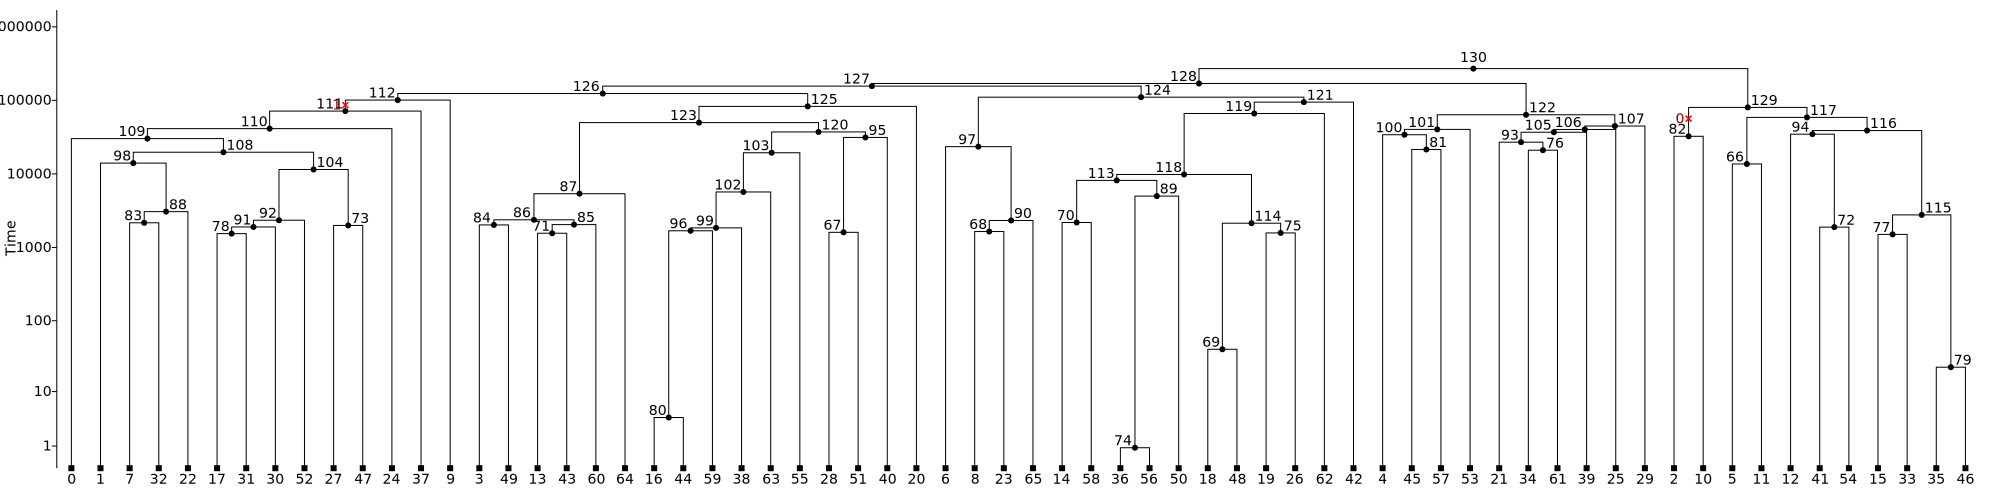

In [43]:
tree = ts.first()
y_tick_pos = [1e0,1e1,1e2,1e3,1e4,1e5,1e6] 
tree.draw_svg(time_scale="log_time", y_axis=True, size=(2*1e3,1e3/2), y_ticks=y_tick_pos, min_time=0, max_time=y_tick_pos[-1])

estimate dispersal using full tree structure

In [44]:
sts0, samples0 = shared_times(tree, ts.samples(), tCutoff=None)
locs0 = [locations[i] for i in samples0[0]]
mles_to_km2(mle_dispersal_tree(locs0, sts0[0]),meanlon)[0]

47.99170088708219

which is much higher than the dispersal estimate using pairwise data only

In [45]:
ys[0]

14.489190136554827

let's get to the bottom of this difference. if we ignore the structure of the tree and calculate the dispersal rate pairwise, but using the MVN approach, we should get nearly the same answer as we did above (with some minor conversion differences)

In [46]:
samples = ts.samples()
k = len(samples)
pair_mles = []
for i in range(k):
    for j in range(i):
        sts0, samples0 = shared_times(tree, [i,j], tCutoff=None)
        locs0 = [locations[i], locations[j]]
        mle = mles_to_km2(mle_dispersal_tree(locs0, sts0[0]),meanlon)[0]
        pair_mles.append(mle)
np.mean(pair_mles)

9.91869142612843

this is close, so it is not an error with the algorithm, but instead something about using the entire tree structure

to investigate, let's look at all the pairwise estimates

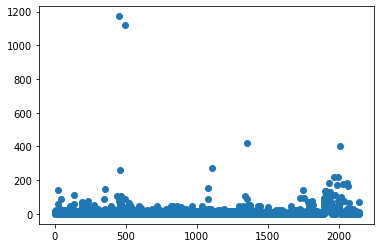

In [47]:
plt.scatter(range(len(pair_mles)), pair_mles)
# plt.yscale('log')
plt.show()

there are 2 massive outliers, which don't have enough weight to affect the average of pairwise estimates, but could be heavily influencing the full tree estimates

so let's remove them. first find which samples are causing the outliers

In [48]:
samples = ts.samples()
k = len(samples)
for i in range(k):
    for j in range(i):
        sts0, samples0 = shared_times(tree, [i,j], tCutoff=None)
        locs0 = [locations[i], locations[j]]
        mle = mles_to_km2(mle_dispersal_tree(locs0, sts0[0]),meanlon)[0]
        if mle>1e3:
            print(i,j, [population_ixs[k] for k in [i,j]])

30 17 [0, 0]
31 30 [0, 0]


In [49]:
px.scatter_geo(lon=locations[[30,17,31],0],lat=locations[[30,17,31],1], hover_name=[30,17,31])

it looks to be sample 30, which is too closely related to some samples from the same group (eurasians).

when we remove this sample the dispersal estimate drops to

In [50]:
sts0, samples0 = shared_times(tree, [i for i in ts.samples() if i!=30], tCutoff=None)
locs0 = [locations[k] for k in samples0[0]]
mles_to_km2(mle_dispersal_tree(locs0, sts0[0]),meanlon)[0]

27.780081441004146

if it was the same samples causing this issue at every tree then the fix would be simple.

let's take the next tree that we use in the analysis (every 100th)

In [51]:
tree = ts.at_index(100)

and calculate dispersal rate using the full tree

In [52]:
sts0, samples0 = shared_times(tree, ts.samples(), tCutoff=None)
locs0 = [locations[k] for k in samples0[0]]
mles_to_km2(mle_dispersal_tree(locs0, sts0[0]),meanlon)[0]

57.57205444847671

via the pairwise approach we get

In [53]:
samples = ts.samples()
k = len(samples)
pair_mles = []
for i in range(k):
    for j in range(i):
        sts0, samples0 = shared_times(tree, [i,j], tCutoff=None)
        locs0 = [locations[i], locations[j]]
        mle = mles_to_km2(mle_dispersal_tree(locs0, sts0[0]),meanlon)[0]
        pair_mles.append(mle)
np.mean(pair_mles)

6.387132799262794

which again has some outliers

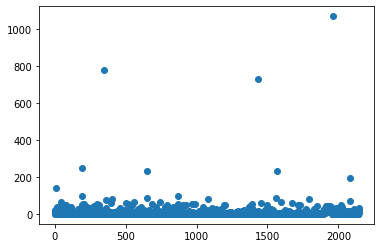

In [54]:
plt.scatter(range(len(pair_mles)), pair_mles)
# plt.yscale('log')
plt.show()

the offending samples are

In [55]:
samples = ts.samples()
k = len(samples)
for i in range(k):
    for j in range(i):
        sts0, samples0 = shared_times(tree, [i,j], tCutoff=None)
        locs0 = [locations[i], locations[j]]
        mle = mles_to_km2(mle_dispersal_tree(locs0, sts0[0]),meanlon)[0]
        if mle>5e2:
            print(i,j, [population_ixs[k] for k in [i,j]])

27 0 [0, 0]
54 5 [0, 0]
63 10 [0, 0]


unfortunately these are different samples than the first tree. so the fix isn't quite so easy.

removing these samples the dispersal estimate drops to

In [56]:
sts0, samples0 = shared_times(tree, [i for i in ts.samples() if i not in [0,27,54,5,63,10]], tCutoff=None)
locs0 = [locations[k] for k in samples0[0]]
mles_to_km2(mle_dispersal_tree(locs0, sts0[0]),meanlon)[0]

18.306039185977376

if we're going to get reasonable dispersal estimates from the trees we're going to have to tone down these outliers.

# branch length sampling

so it looks like, with a single estimate of the branch lengths, we can get some really high dispersal estimates. it also looks like these high estimates could be driven by uncertainty in branch lengths due to few mutations. this is why we need to sample branch lengths many times.

load many samples of a tree

In [57]:
def load_trees(newickfile, max_n_trees=1e6):
    '''load newick files as list of tree sequences'''
    
    tss = []
    with open(newickfile, mode='r') as file:
        for i,line in enumerate(file): 
            if i>0 and i<max_n_trees+1: #skip header and don't load too many trees
                tree = line.split()[4] #extract newick string only (Relate adds some info beforehand)
                tss.append(tsconvert.from_newick(tree)) #convert to tskit "tree sequence" (only one tree)
    
    return tss

In [58]:
nsamples = 1000 #number of samples of branch lengths
# bps = [] #pairs of start and stop sites (not necessarily in numerical order!) these are the positions of the first and last SNP in each tree, not the actual breakpoints
# tsss = [] #treeseqs (in same order as bps)
# string = basename%(CHR,Ne,m,numiter,threshold) + '_*bps_%dnsamples.newick'%nsamples
# for newickfile in glob.iglob(string):
#     bps.append(list(map(int,re.search('threshold_(.+?)bps_%dnsamples.newick'%nsamples, newickfile).group(1).split('-')))) #load bps at each tree
#     tsss.append(load_trees(newickfile, max_n_trees=nsamples)) #load trees
newickfile = basename%(CHR,Ne,m,numiter,threshold) + '_3947-4001bps_%dnsamples.newick'%nsamples
tss = load_trees(newickfile)

and calculate the dispersal rate from each

In [59]:
ts = tss[0] #all samples at the tree have the same sample order
mle_samples = []
for ts in tss:
    tree = ts.first()
    sts0, samples0 = shared_times(tree, ts.samples(), tCutoff=None)
    locs0 = [locations[int(ts.node(i).metadata['name'])] for i in samples0[0]]
    mle = mles_to_km2(mle_dispersal_tree(locs0, sts0[0]),meanlon)[0]
    mle_samples.append(mle)

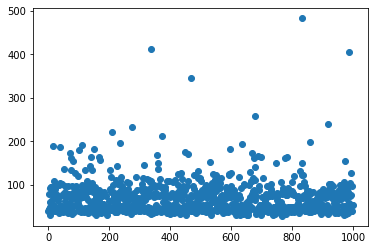

In [60]:
plt.scatter(range(len(mle_samples)), mle_samples)
plt.show()

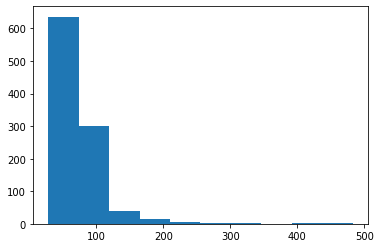

In [61]:
plt.hist(mle_samples)
plt.show()

this has mean (equivalent to the BLUP approach)

In [62]:
mean = np.mean(mle_samples)
mean

68.43189309970957

and isn't too far off an exponential distribution, just with a minimum greater than 0

In [63]:
xs = np.linspace(0,max(mle_samples),1000)
ys = [1/mean * np.exp(-x/mean) for x in xs]

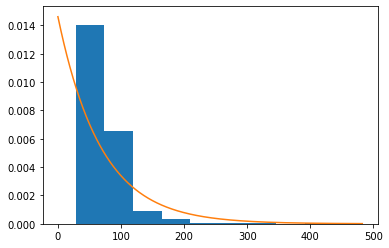

In [64]:
plt.hist(mle_samples, density=True)
plt.plot(xs, ys)
plt.show()

(could try a gamma...)

# importance weights

we may want to weight each sampled tree differently, based on its probability under our spatial model vs its probability under Relate's panmictic model. it's not clear how this will affect the estimate

get probability of each tree under panmictic model

In [65]:
def _log_coal_density(times, Nes, epochs=None, tCutoff=None):

    """
    log probability of coalescent times under standard neutral/panmictic coalescent
    """

    if Nes is None:
        print('must supply Ne to get probability of coalescence times')
        return

    if epochs is None and len(Nes) == 1:
        epochs = [0, max(times)] #one big epoch
        Nes = [Nes[0], Nes[0]] #repeat the effective population size so same length as epochs 

    logp = 0 #initialize log probability
    prevt = 0 #initialize time
    prevLambda = 0 #initialize coalescent intensity
    n = len(times) + 1 #number of samples
    if tCutoff is not None:
        times = times[times < tCutoff] #ignore old times
    myIntensityMemos = _coal_intensity_memos(epochs, Nes) #intensities up to end of each epoch

    # probability of each coalescence time
    for i,t in enumerate(times): #for each coalescence event i at time t
        k = n-i #number of lineages remaining
        kchoose2 = k * (k - 1) / 2 #binomial coefficient
        Lambda = _coal_intensity_using_memos(t, epochs, myIntensityMemos, Nes) #coalescent intensity up to time t
        ie = np.digitize(np.array([t]), epochs) #epoch at the time of coalescence
        logpk = np.log(kchoose2 * 1 / (2 * Nes[ie])) - kchoose2 * (Lambda - prevLambda) #log probability (waiting times are time-inhomogeneous exponentially distributed)
        logp += logpk
        prevt = t
        prevLambda = Lambda

    # now add the probability of lineages not coalescing by tCutoff
    if k > 1 and tCutoff is not None: #if we have more than one lineage remaining
        k -= 1 #after the last coalescence event we have one less sample
        kchoose2 = k * (k - 1) / 2 #binomial coefficient
        Lambda = _coal_intensity_using_memos(tCutoff, epochs, myIntensityMemos, Nes) #coalescent intensity up to time tCutoff
        logPk = - kchoose2 * (Lambda - prevLambda) #log probability of no coalescence
        logp += logPk

    return logp[0]

def _coal_intensity_using_memos(t, epochs, intensityMemos, Nes):

    """
    add coal intensity up to time t
    """

    iEpoch = int(np.digitize(np.array([t]), epochs)[0] - 1) #epoch 
    t1 = epochs[iEpoch] #time at which the previous epoch ended
    Lambda = intensityMemos[iEpoch] #intensity up to end of previous epoch
    Lambda += 1 / (2 * Nes[iEpoch]) * (t - t1) #add intensity for time in current epoch
    return Lambda

def _coal_intensity_memos(epochs, Nes):

    """
    coalescence intensity up to the end of each epoch
    """

    Lambda = np.zeros(len(epochs))
    for ie in range(1, len(epochs)):
        t0 = epochs[ie - 1] #start time
        t1 = epochs[ie] #end time
        Lambda[ie] = (t1 - t0) #elapsed time
        Lambda[ie] *= 1 / (2 * Nes[ie - 1]) #multiply by coalescence intensity
        Lambda[ie] += Lambda[ie - 1] #add previous intensity

    return Lambda

In [66]:
coalfile=basename+'.coal'
epochs, Nes = get_epochs(coalfile%(CHR,Ne,m,numiter,threshold))

In [67]:
logpcoals = []
for ts in tss:
    tree = ts.first()
    cts = sorted([tree.time(i) for i in tree.nodes() if not tree.is_sample(i)])
    logpcoal = _log_coal_density(times=cts, Nes=Nes, epochs=epochs, tCutoff=None)
    logpcoals.append(logpcoal)

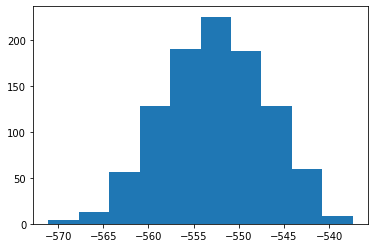

In [68]:
plt.hist(logpcoals)
plt.show()

and how do these log probabilities correspond to dispersal estimates?

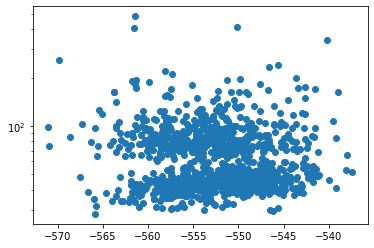

In [69]:
plt.scatter(logpcoals, mle_samples)
plt.yscale('log')
plt.show()

unfortunately doesn't look like too much of a pattern - i guess we can only hope the low estimates have higher probability under branching brownian motion

to get the probability of each tree under our spatial model (birth process) we need to estimate the birth rate. 

In [70]:
import math

def _log_birth_density(times, phi, tCutoff=None, condition_on_n=True):

    """
    log probability of coalescence times given Yule process with splitting rate phi
    """

    n = len(times) + 1 #number of samples is 1 more than number of coalescence events
    if tCutoff is None:
        T = times[-1]
    else:
        T = min(tCutoff, times[-1]) #furthest time in past we are interested in is the min of the cutoff time and the oldest coalesence event
    times = T - times #switch to forward in time perspective from T
    times = np.sort(times[times>0]) #remove older coalescence events (we'll assume panmixia beyond tCutoff, so this will cancel out in importance sampling)
    n0 = n - len(times) #number of lineages at time T

    logp = 0 #initialize log probability
    prevt = 0 #initialize time
    # probability of each coalescence time
    for i, t in enumerate(times): #for each coalescence event i at time t
        k = n0 + i #number of lineages before the event
        logp += np.log(k * phi) - k * phi *  (t - prevt) #log probability of waiting time  t-prevt (waiting times are exponentially distributed with rate k*phi)
        prevt = t #update time

    #add probability of no coalescence to present time (from most recent coalescence to present, with n samples and rate n*phi)
    logp += - n * phi * (T - prevt)

    #condition on having n samples from n0 in time T
    if condition_on_n:
        logp -= np.log(math.comb(n - 1, n - n0) * (1 - np.exp(-phi * T))**(n - n0)) - phi * n0 * T # see page 234 of https://www.pitt.edu/~super7/19011-20001/19531.pdf for two different expressions

    return logp

so we just go full numeric mle

In [71]:
import scipy.sparse as sp

def _sum_mc(locations, shared_times, samples, important=True, coal_times=None, logpcoals=None, 
            scale_phi=1, tCutoff=None, tsplits=[], n=None):
    """
    negative log composite likelihood as a function of list of parameters, x
    """

    E = len(tsplits) + 1 #number of epochs
    L = len(samples) #number of loci
    
    # use n trees at each locus
    M = len(samples[0]) #number of trees at each locus
    if n < M:
        shared_times = [i[0:n] for i in shared_times] 
        samples = [i[0:n] for i in samples]
        if important:
            coal_times = [i[0:n] for i in coal_times]
            logpcoals = [i[0:n] for i in logpcoals]
    if not important:
        coal_times = [None for _ in samples]
        logpcoals = [None for _ in samples]
    
    def sumf(x):
        """
        negative log composite likelihood of list of parameters, x
        """
        
        # convert list of parameters to covariance matrices and birth rate
        covs, phi = _covs_phi(x, E, important) 
        
        # unscale phi
        if important:
            phi = phi/scale_phi
        
        # get negative log composite likelihood 
        g = 0
        for i in range(L):
            # subtract summed log likelihood at each locus 
            g -= _mc(
                     locations=locations,
                     shared_times=shared_times[i],
                     samples=samples[i],
                     covs=covs,
                     important=important,
                     coal_times=coal_times[i],
                     logpcoals=logpcoals[i],
                     phi=phi,
                     tCutoff=tCutoff,
                     tsplits=tsplits
                    )
        return g

    return sumf

def _covs_phi(x, E=1, important=True):
    """
    Convert list of parameters being estimated into covariance matrices and birth rate
    """
    
    # make list of covariance matrices in each epoch
    covs = [] 
    for e in range(E):
        covs.append(sds_rho_to_cov_matrix(x[3*e],x[3*e + 1],x[3*e + 2]))
        # TODO: write this more generally for any dimension

    phi = None
    if important:
        phi = x[-1] #last parameter is birth rate        

    return [covs, phi]

def sds_rho_to_cov_matrix(sdx,sdy,rho):
    """
    Convert sds and correlation to 2x2 covariance matrix
    """
    
    cov = sdx*sdy*rho
    C = np.array([[sdx**2, cov], [cov, sdy**2]])
    
    return C

def _mc(locations, shared_times, samples, covs, important=True, coal_times=None, logpcoals=None, phi=None, tCutoff=None, tsplits=[]):
    """
    Monte Carlo estimate of log of likelihood ratio of the locations given parameters (covs,phi) vs data given standard coalescent
    """

    M = len(samples) #number of trees

    if coal_times is None and logpcoals is None:
        coal_times, logpcoals = [None for _ in range(M)], [None for _ in range(M)]

    LLRs = np.zeros(M) #log likelihood ratio of each tree
    for i, (shared_time, sample, coal_time, logpcoal) in enumerate(zip(shared_times, samples, coal_times, logpcoals)):

        LLRs[i] = _log_likelihoodratio(locations, shared_time, sample, covs, important=important, coal_times=coal_time, logpcoals=logpcoal, phi=phi, tCutoff=tCutoff, tsplits=tsplits)

    LLRhat = _logsumexp(LLRs) - np.log(M) #average over trees at this locus

    return LLRhat

def _log_likelihoodratio(locations, shared_times, samples, covs, important=True, coal_times=None, logpcoals=None, phi=None, tCutoff=None, tsplits=[]):   

    """ 
    Log of likelihood ratio of locations given parameters (covs,phi) vs data given standard coalescent
    """

    LLR = 0
    # loop over subtrees
    for shared_time, sample in zip(shared_times, samples):
        if len(shared_time) > 1: #need at least two samples in subtree to mean center and still have info on dispersal rate
            # add log likelihood of locations given shared evolutionary times and dispersal matrix
            LLR += _location_loglikelihood(locations[sample], shared_time, covs, tsplits)
    if important:
        # add log probability of coalescence times given pure birth process with rate phi
        LLR += _log_birth_density(coal_times, phi, tCutoff) 
        # subtract log probability density of coalescence times under standard coalescent
        LLR -= logpcoals 

    return LLR

def _location_loglikelihood(locations, shared_time, covs, tsplits=[]):

    """
    Log likelihood of locations given mean location and dispersal rate 
    """

    n = len(locations) #number of samples
    Tmat = np.identity(n) - [[1/n for _ in range(n)] for _ in range(n)]; Tmat = Tmat[0:-1]; #matrix for mean centering and dropping one sample

    # mean center locations
    locs = np.matmul(Tmat, locations) #mean center locations and drop last sample (bc lost a degree of freedom when taking mean); see Lee & Coop 2017 Genetics eq A.16; note numpy broadcasts across the columns in locs
    x = np.transpose(locs).flatten() #write locations as vector (all x locations first, then all y, etc)
    mean = np.zeros(len(x)) #mean of mvn

    # if we don't allow dispersal to vary across time
    if tsplits == []:

        stime = np.matmul(Tmat, np.matmul(shared_time, np.transpose(Tmat))) #mean center shared times
        cov = np.kron(covs[0], stime) #covariance of mvn

    else:

        # times in each epoch
        tsplits = [0] + tsplits #append 0 to front of list of split times
        Ts = [tsplits[i + 1] - tsplits[i] for i in range(len(tsplits) - 1)] #amount of time in all but the most distant epoch
        T = shared_time[0][0] #tmrca
        Ts.append(T - tsplits[-1]) #add time in the most distant epoch

        #shared times in each epoch
        stimes = [] #place to store shared time matrix in each epoch
        stimes.append(np.minimum(shared_time, Ts[-1])) #shared times in most distant epoch
        for i in range(len(tsplits) - 1):
            stimes.append(np.minimum(np.maximum(shared_time - (T - tsplits[-1 - i]), 0), Ts[-2 - i])) #shared times in each most recent epochs (note this means the theta produced will go in chronological order, from most distant to most recent)

        # mean center shared times in each epoch (note this makes each row and column sum to zero)    
        for i,stime in enumerate(stimes):
            stimes[i] = np.matmul(Tmat, np.matmul(stime, np.transpose(Tmat))) #mean center covariance matrix (see eq A.18 in Lee & Coop 2017 Genetics)

        # sum up covariance matrices
        cov = np.zeros((len(x), len(x))) #covariance matrix of mvn
        for i,stime in enumerate(stimes):
            cov += np.kron(covs[i], stime) #covariance matrix for epoch i

    #if np.linalg.matrix_rank(cov) == len(cov):
    return _lognormpdf(x, mean, cov)

def _lognormpdf(x, mu, S, relative=True):

    """
    Calculate log probability density of x, when x ~ N(mu,S)
    """

    # log of coefficient in front of exponential (times -2)
    nx = len(S)
    if relative == False:
        norm_coeff = nx * math.log(2 * math.pi) + np.linalg.slogdet(S)[1]
    else:
        norm_coeff = np.linalg.slogdet(S)[1] #just care about relative likelihood so drop the constant

    # term in exponential (times -2)
    err = x - mu #difference between mean and data
    if sp.issparse(S):
        numerator = spln.spsolve(S, err).T.dot(err) #use faster sparse methods if possible
    else:
        numerator = np.linalg.solve(S, err).T.dot(err) #just a fancy way of calculating err.T * S^-1  * err

    return -0.5 * (norm_coeff + numerator) #add the two terms together

def _logsumexp(a):

    """
    take the log of a sum of exponentials without losing information
    """

    a_max = np.max(a) #max element in list a
    tmp = np.exp(a - a_max) #now subtract off the max from each a before taking exponential (ie divide sum of exponentials by exp(a_max))
    s = np.sum(tmp) #and sum those up
    out = np.log(s) #and take log
    out += a_max  #and then add max element back on (ie multiply sum by exp(a_max), ie add log(exp(a_max)) to logged sum)

    return out

In [72]:
import time

from scipy.optimize import minimize

def cov_matrix_to_sds_rho(C):
    """
    Convert 2x2 covariance matrix to sds and correlation
    """
    
    sdx = C[0,0]**0.5
    sdy = C[1,1]**0.5
    rho = C[0,1]/(sdx * sdy) #note that small sdx and sdy will raise errors
    
    return [sdx, sdy, rho]

def mle_dispersal(locations, shared_times, samples, 
                  n=None, force_numeric=False, BLUP=False,
                  covs0=None, bnds=None, 
                  important=True, coal_times=None, logpcoals=None, 
                  phi0=None, scale_phi=None, 
                  method='L-BFGS-B', options=None, 
                  tCutoff=None, tsplits=[],
                  quiet=False
                  ):
    """
    Estimate maximum likelihood dispersal rate (and possibly branching rate) given sample locations and processed trees.
    """

    L = len(samples)
    if not quiet:
        print('inferring dispersal rate from',L,'loci')
    
    M = len(samples[0])
    if n == None:
        n = M
    if not quiet:
        print('using',n,'of',M,'trees per locus')
    
    d = len(locations[0])
    if not quiet:
        print('space has',d,'dimensions')
    
    E = len(tsplits) + 1
    if not quiet:
        print('assuming',E,'dispersal epochs')
    
    exact_mle = mle_dispersal_exact(locations, shared_times, samples, tree_ix=0) #exact mle using first tree at each locus
    
    if E==1 and (M==1 or n==1) and not force_numeric:
        
        if not quiet:
            print('only 1 epoch and only 1 tree per locus: calculating exact MLE analytically')

        return exact_mle #could improve so that n chooses which tree_ix to use

    elif BLUP and not important and E==1 and not force_numeric:
        
        if not quiet:
            print('using BLUP approach: weighted average of exact MLEs')
        
        return mle_dispersal_blup(locations, shared_times, samples)
    
    else:
        
        if not quiet:
            print('estimating the MLE numerically')

        # initial guess at parameters
        if covs0 is None:
            covs0 = [exact_mle for _ in range(E)] #covariance matrices in each epoch
        if important:
            nt = len(locations) #number of lineages at present
            if tCutoff is None:
                n0 = 1 #number of lineages at start
                t = np.mean([stss[0][0][0,0] for stss in shared_times]) #average time to present, over loci (at first tree)
            else:
                n0 = np.mean([len(smpls[0]) for smpls in samples]) #average number of lineages at tCutoff over loci (at first tree)
                t = tCutoff
            phi0 = np.log(nt/n0)/t #phylogenetic birth rate
        
        # convert parameters to list of sds, correlations, and (potentially) birth rate
        x0 = [cov_matrix_to_sds_rho(i) for i in covs0]
        x0 = [item for sublist in x0 for item in sublist]
        if important:
            x0.append(phi0)
        if not quiet:
            print('initial parameter values:',x0)
        
        # scale phi to put on same scale as dispersal parameters, to improve numerical search
        if important and scale_phi is None:
            scale_phi = np.mean(x0[:-1])/phi0
            if not quiet:
                print('scaling phi by',scale_phi)
        
        # negative composite log likelihood ratio, as function of x
        f = _sum_mc(locations, shared_times, samples, important=important, coal_times=coal_times, logpcoals=logpcoals, 
                    scale_phi=scale_phi, tCutoff=tCutoff, tsplits=tsplits, n=n)
    
        # impose bounds on parameters
        if bnds is None:
            bnds = [[(1e-6,None),(1e-6,None),(-0.99,0.99)] for _ in covs0]
            bnds = [item for sublist in bnds for item in sublist]
            if important:
                bnds.append((1e-6,None))
            bnds = tuple(bnds)
        
        if not quiet:
            print('searching for maximum likelihood parameters...')
        t0 = time.time()

        m = minimize(f, x0=x0, bounds=bnds, method=method, options=options) #find MLE

#         print('the max is ', m.x)
        if not quiet:
            print('finding the max took', time.time()-t0, 'seconds')

        return m


In [73]:
def mle_dispersal_exact(locations, shared_times, samples, tree_ix=0):
        
    """
    Analytically calculate maximum likelihood dispersal rate given sample locations and shared time matrices.
    """
    
    d = len(locations[0]) #number of spatial dimensions
    
    Ksum = 0
    KVsum = np.zeros((d,d))
    # loop over loci
    for locus,stss in enumerate(shared_times):

        sts = stss[tree_ix] #list of shared time matrices for each subtree
        sample_lists = samples[locus][tree_ix] #list of sample lists for each subtree

        ksum = 0
        kvsum = np.zeros((d,d))
        # loop over subtrees
        for subtree,st in enumerate(sts): 

            sample_list = sample_lists[subtree]
            k = len(sample_list)

            # calculate subtree weight and weighted mle dispersal rate
            if k > 1: #need more than 1 sample to estimate dispersal rate 
                ksum += k-1 #weight
                locs = [locations[i] for i in sample_list]
                v = mle_dispersal_tree(locations=locs, shared_times=st) #mle
                kvsum += (k-1)*v #weighted mle

        KVsum += kvsum
        Ksum += ksum

    return KVsum/Ksum

In [74]:
def mle_dispersal_blup(locations, shared_times, samples):
        
    """
    BLUP
    """
    
    d = len(locations[0]) #number of spatial dimensions
    nloci = len(samples) #number of loci
    ntrees = len(samples[0]) #number of trees at a locus
    
#     genome_sum = 0
    ksum = 0
    kvsum = np.zeros((d,d))
    # loop over loci
    for locus,stss in enumerate(shared_times):

#         locus_sum = 0
        kisum = 0
        kvisum = np.zeros((d,d))
        # loop over trees
        for tree, sts in enumerate(stss):

            sample_lists = samples[locus][tree] #list of sample lists for each subtree

            kijsum = 0
            kvijsum = np.zeros((d,d))
            # loop over subtrees
            for subtree,st in enumerate(sts): 

                sample_list = sample_lists[subtree]
                k = len(sample_list)

                # calculate subtree weight and weighted mle dispersal rate
                if k > 1: #need more than 1 sample to estimate dispersal rate 
                    kijsum += k-1 #weight
                    locs = [locations[i] for i in sample_list]
                    v = mle_dispersal_tree(locations=locs, shared_times=st) #mle
                    kvijsum += (k-1)*v #weighted mle

# simple averaging
#             locus_sum += kvijsum/kijsum #add MLE at tree
#         genome_sum += locus_sum/ntrees #add avg MLE over trees
#     return genome_sum/nloci #avg MLE over loci

# weight influenced by number of subtrees
            kisum += kijsum
            kvisum += kvijsum
        ksum += kisum
        kvsum += kvisum
        
    return kvsum/ksum

calculate times

In [75]:
stss = []
smplss = []
ctss = []
logpcoals = []
for ts in tss:
    tree = ts.first()
    sts, smpls = shared_times(tree, ts.samples(), tCutoff=None)
    smpls = [[int(ts.node(node).metadata['name']) for node in s] for s in smpls] #to align with metadata
    stss.append(sts)
    smplss.append(smpls)
    cts = sorted([tree.time(i) for i in tree.nodes() if not tree.is_sample(i)])
    ctss.append(cts)
    logpcoal = _log_coal_density(times=cts, Nes=Nes, epochs=epochs, tCutoff=None)
    logpcoals.append(logpcoal)

check we get same as above (simple averaging of MLEs, ie BLUP) without importance weights

In [76]:
mle = mle_dispersal(locations, [stss], [smplss], BLUP=True, important=False)
mles_to_km2(mle,meanlon)[0]

inferring dispersal rate from 1 loci
using 1000 of 1000 trees per locus
space has 2 dimensions
assuming 1 dispersal epochs
using BLUP approach: weighted average of exact MLEs


68.43189309970961

good. we can compare to the true mle without importance weights too

In [77]:
mle = mle_dispersal(locations, [stss], [smplss], covs0=None, important=False)
sdx, sdy, rho = mle.x
cov = sds_rho_to_cov_matrix(sdx, sdy, rho)
mles_to_km2(cov,meanlon)[0]

inferring dispersal rate from 1 loci
using 1000 of 1000 trees per locus
space has 2 dimensions
assuming 1 dispersal epochs
estimating the MLE numerically
initial parameter values: [0.057829574115394154, 0.05848049784390098, 0.46778860823288215]
searching for maximum likelihood parameters...
finding the max took 84.53603315353394 seconds


37.6592901143797

interestingly, this is quite a bit lower. not sure why. flat or bumpy likelihood surface? INVESTIGATE

and now for importance weights

In [78]:
mle = mle_dispersal(locations, [stss], [smplss], covs0=None, important=True, coal_times=np.array([ctss]), logpcoals=[logpcoals])
sdx, sdy, rho, phi = mle.x
cov = sds_rho_to_cov_matrix(sdx, sdy, rho)
mles_to_km2(cov,meanlon)[0]

inferring dispersal rate from 1 loci
using 1000 of 1000 trees per locus
space has 2 dimensions
assuming 1 dispersal epochs
estimating the MLE numerically
initial parameter values: [0.057829574115394154, 0.05848049784390098, 0.46778860823288215, 9.080203050814812e-06]
scaling phi by 21442.203326784384
searching for maximum likelihood parameters...


/tmp/ipykernel_42256/1067539498.py:31: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_42256/1978905246.py:197: RuntimeWarning:

invalid value encountered in subtract



finding the max took 57.06888747215271 seconds


42.23422669867604

which doesn't change the answer much

# sampling trees at multiple loci

In [79]:
bps = [] #pairs of start and stop sites (not necessarily in numerical order!) these are the positions of the first and last SNP in each tree, not the actual breakpoints
newickfiles = []

tsss = []
string = basename%(CHR,Ne,m,numiter,threshold) + '_*bps_%dnsamples.newick'%nsamples
for newickfile in glob.iglob(string):
    bps.append(list(map(int,re.search('threshold_(.+?)bps_%dnsamples.newick'%nsamples, newickfile).group(1).split('-')))) #load bps at each tree
#     tsss.append(load_trees(newickfile, max_n_trees=nsamples)) #load trees
    newickfiles.append(newickfile)

total number of loci

In [80]:
nloci = len(bps)

load trees for a few loci

In [81]:
nsamples = 1000 #number of samples of branch lengths
L = 2 #number of loci to use
tsss = []
for newickfile in newickfiles[:L]:
    tsss.append(load_trees(newickfile, max_n_trees=nsamples)) #load trees

calculate times

In [82]:
def coal_times(tree):
    '''coalescence times in tskit tree'''

    cts = [tree.time(i) for i in tree.nodes() if not tree.is_sample(i)]
    
    return sorted(cts)

def get_times(tss, tCutoff=None):
    '''shared times and coalescence times in list of one-tree tskit treesequences'''

    stss = [] #shared times between each pair of samples
    smplss = [] #order of samples in shared times matrix
    ctss = [] #coalescence times
    
    for ts in tss:
        
        tree = ts.first()
        sts, smpls = shared_times(tree, ts.samples(), tCutoff)
        cts = coal_times(tree)
        smpls = [[int(ts.node(node).metadata['name']) for node in s] for s in smpls] #to align with metadata
        
        stss.append(sts)
        smplss.append(smpls)
        ctss.append(cts)

    return stss, smplss, ctss

In [83]:
TCUT = None #CHOOSE TIME CUTOFF

stsss = []
smplsss = []
ctsss = []
for tss in tsss: #for each locus
    stss, smplss, ctss = get_times(tss, tCutoff=TCUT)
    stsss.append(stss)
    smplsss.append(smplss)
    ctsss.append(ctss)

In [84]:
logpcoalss = []
for ctss in ctsss:
    logpcoals = []
    for cts in ctss:
        logpcoal = _log_coal_density(times=cts, Nes=Nes, epochs=epochs, tCutoff=None)
        logpcoals.append(logpcoal)
    logpcoalss.append(logpcoals)

In [85]:
mle = mle_dispersal(locations, stsss, smplsss, BLUP=True, important=False)
mles_to_km2(mle,meanlon)[0]

inferring dispersal rate from 2 loci
using 1000 of 1000 trees per locus
space has 2 dimensions
assuming 1 dispersal epochs
using BLUP approach: weighted average of exact MLEs


105.45661804684715

In [86]:
mle = mle_dispersal(locations, stsss, smplsss, covs0=None, important=False)
sdx, sdy, rho = mle.x
cov = sds_rho_to_cov_matrix(sdx, sdy, rho)
mles_to_km2(cov,meanlon)[0]

inferring dispersal rate from 2 loci
using 1000 of 1000 trees per locus
space has 2 dimensions
assuming 1 dispersal epochs
estimating the MLE numerically
initial parameter values: [0.06556929834619202, 0.052379079753899244, 0.6228522009337806]
searching for maximum likelihood parameters...
finding the max took 135.1586925983429 seconds


41.09477563886628

In [87]:
mle = mle_dispersal(locations, stsss, smplsss, covs0=None, important=True, coal_times=np.array(ctsss), logpcoals=logpcoalss)
sdx, sdy, rho, phi = mle.x
cov = sds_rho_to_cov_matrix(sdx, sdy, rho)
mles_to_km2(cov,meanlon)[0]

inferring dispersal rate from 2 loci
using 1000 of 1000 trees per locus
space has 2 dimensions
assuming 1 dispersal epochs
estimating the MLE numerically
initial parameter values: [0.06556929834619202, 0.052379079753899244, 0.6228522009337806, 1.4785537974664287e-05]
scaling phi by 16701.017356808803
searching for maximum likelihood parameters...


/tmp/ipykernel_42256/1067539498.py:31: RuntimeWarning:

divide by zero encountered in log

/tmp/ipykernel_42256/1978905246.py:197: RuntimeWarning:

invalid value encountered in subtract



finding the max took 116.09680986404419 seconds


31.82846057724415

# scaling up

ok, so now that we have the code working, we should try to speed this numerical optimization up. 

In [88]:
def blup_test(nsamples, L, TCUT=None):
    
    t0 = time.time()
    
    # load treeseqs
    tsss = []
    for newickfile in newickfiles[:L]:
        tsss.append(load_trees(newickfile, max_n_trees=nsamples)) #load trees
    
    t1 = time.time()
    
    # process
    stsss = []
    smplsss = []
    ctsss = []
    for tss in tsss: #for each locus
        stss, smplss, ctss = get_times(tss, tCutoff=TCUT)
        stsss.append(stss)
        smplsss.append(smplss)
        ctsss.append(ctss)
            
    # importance weights
    logpcoalss = []
    for ctss in ctsss:
        logpcoals = []
        for cts in ctss:
            logpcoal = _log_coal_density(times=cts, Nes=Nes, epochs=epochs, tCutoff=None)
            logpcoals.append(logpcoal)
        logpcoalss.append(logpcoals)
     
    t2 = time.time()
    
    # blup mle
    mle = mle_dispersal(locations, stsss, smplsss, BLUP=True, important=False, quiet=True)
    meanlon = np.mean(locations[:,0])
    mle0 = mles_to_km2(mle,meanlon)[0]
    
    t3 = time.time()
    
    return mle0, t1-t0, t2-t1, t3-t2

let's see how our estimates and computation time scale with the number of loci

In [89]:
mles = []
times = []
loci = range(1,nloci,10)
nsamples = 1
for l in loci:
    mle, t1, t2, t3 = blup_test(nsamples, L=l)
    mles.append(mle)
    times.append([t1,t2,t3])
times = np.array(times)

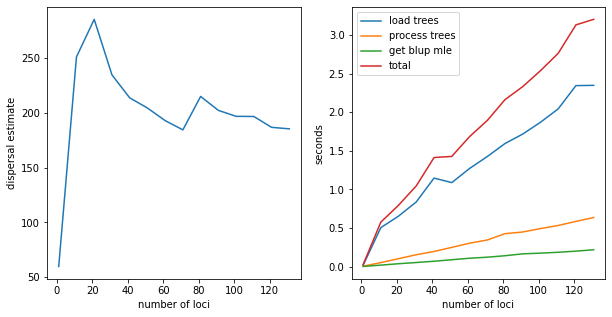

In [90]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].plot(loci,mles)

labels = ['load trees', 'process trees', 'get blup mle']
for column in range(times.shape[1]):
    axs[1].plot(loci,times[:,column], label=labels[column])
axs[1].plot(loci, np.sum(times, axis=1), label='total')

axs[0].set_ylabel('dispersal estimate')

axs[1].set_ylabel('seconds')
axs[1].legend()
    
for ax in axs:
    ax.set_xlabel('number of loci')
plt.show()

so it looks like we need over 100 loci to get a reliable dispersal estimate, and loading and processing takes about 0.025 seconds per tree

In [91]:
mles = []
times = []
L = 1
nsamples = range(1,1001,100)
for n in nsamples:
    mle, t1, t2, t3 = blup_test(nsamples=n, L=L)
    mles.append(mle)
    times.append([t1,t2,t3])
times = np.array(times)

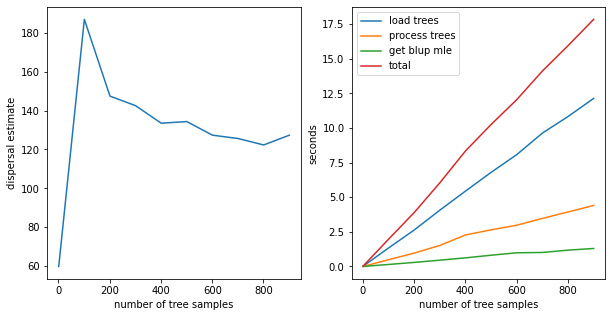

In [92]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].plot(nsamples,mles)

labels = ['load trees', 'process trees', 'get blup mle']
for column in range(times.shape[1]):
    axs[1].plot(nsamples,times[:,column], label=labels[column])
axs[1].plot(nsamples, np.sum(times, axis=1), label='total')

axs[0].set_ylabel('dispersal estimate')

axs[1].set_ylabel('seconds')
axs[1].legend()
    
for ax in axs:
    ax.set_xlabel('number of tree samples')
plt.show()

it looks like we need many more at least 1000 tree samples to get a reliable mle, and time scales similarly (0.02 seconds per tree)

this means that to use 1000 trees at 100 loci loading and processing will take the following number of minutes

In [93]:
1000*100*0.02/60

33.333333333333336

we can parallelize this though, perhaps most simply by loci, each of which will only take the following number of seconds

In [94]:
1000*0.02

20.0

to parallelize here in jupyter we need to write a script to file

In [95]:
%%writefile functions.py

import tsconvert
import numpy as np

def load_and_process_trees(newickfile, max_n_trees=1e6, tCutoff=None, important=False):
    
    # load trees as treeseqs
    tss = [] 
    with open(newickfile, mode='r') as file:
        for i,line in enumerate(file): 
            if i>0 and i<max_n_trees+1: #skip header and don't load too many trees
                tree = line.split()[4] #extract newick string only (Relate adds some info beforehand)
                tss.append(tsconvert.from_newick(tree)) #convert to tskit "tree sequence" (only one tree)
    
    # process trees
    stss, smplss, ctss = get_times(tss, tCutoff)
    logpcoals = None
    if important:
        logpcoals = [_log_coal_density(cts, Nes, epochs, tCutoff) for cts in ctss]
    
    return stss, smplss, ctss, logpcoals

def coal_times(tree):
    '''coalescence times in tskit tree'''

    cts = [tree.time(i) for i in tree.nodes() if not tree.is_sample(i)]
    
    return sorted(cts)

def get_times(tss, tCutoff=None):
    '''shared times and coalescence times in list of one-tree tskit treesequences'''

    stss = [] #shared times between each pair of samples
    smplss = [] #order of samples in shared times matrix
    ctss = [] #coalescence times
    
    for ts in tss:
        
        tree = ts.first()
        sts, smpls = shared_times(tree, ts.samples(), tCutoff)
        cts = coal_times(tree)
        smpls = [[int(ts.node(node).metadata['name']) for node in s] for s in smpls] #to align with metadata
        
        stss.append(sts)
        smplss.append(smpls)
        ctss.append(cts)

    return stss, smplss, ctss

def shared_times(tree, samples, tCutoff=None):
    '''shared times between pairs of samples in tskit tree'''

    T = tree.time(tree.root) #tmrca
    k = len(samples)
    sts = np.zeros((k,k))
    for i in range(k):
        sts[i,i] = T #shared time with self
        for j in range(i):
            st = T - tree.tmrca(samples[i],samples[j]) #shared time of pair
            sts[i,j] = st
            sts[j,i] = st

    if tCutoff is None or tCutoff > T:
        return [sts], [[samples[i] for i in range(k)]] #return a single tree
            
    else:
        shared_time = tCutoff - (T-sts) #shared time since tCutoff

        # get shared times and samples in each subtrees
        sts = [] #start list with shared times in subtree with i
        smpls = [] #samples in this subtree
        taken = [False for _ in range(k)]
        while sum(taken) < k: #while some samples not yet in a subtree
            i = np.argmax(taken == False) #choose next sample not yet in a subtree
            withi = shared_time[i] >= 0 #true if shares time with i
            timesi = shared_time[withi][:, withi] #shared times of subtree with i
            timesi = timesi - np.min(timesi) #trim
            sts.append(timesi) #append        
            smpls.append(samples[np.where(withi)[0]]) #samples in this subtree
            taken = np.array([i[0] or i[1] for i in zip(taken, withi)]) #samples already in a subtree
            
        return sts, smpls #return list of shared times and samples in each subtree

Overwriting functions.py


load some packages

In [96]:
from functools import partial
from tqdm import tqdm
from multiprocess import Pool
from importlib import reload
import functions
reload(functions)
from functions import load_and_process_trees

and run

In [97]:
L = 100 #number of loci
n = 1 #number of trees per locus
filenames = newickfiles[:L]

max_pool = 2 #number of threads: max 10 for memory sake

with Pool(max_pool) as p:
    pool_outputs = list(
        tqdm(
            p.imap(partial(load_and_process_trees, max_n_trees=n),
                   filenames),
            total=len(filenames)
        )
    )    

100%|██████████| 100/100 [00:01<00:00, 59.62it/s]


but the better thing to do will be to process all these trees via SLURM/Snakemake and save the processed trees to file. we'll have to load all the processed trees to estimate a joint dispersal rate, which may therefore also be best done in SLURM for memory's sake.

ok, so now we get the shared and coalescent times via files

check how long it takes to load shared times and estimate dispersal at every tree at a locus

In [99]:
stss = np.load('../data/T2T_Athaliana_66.Chr4.nomissing.nohet.justSNPs_haploid_polarized_masked_100000Ne_7e-9m_popsize_10numiter_0.5threshold_3947-4001bps_1000nsamples_sts.npy')
t0 = time.time()
sigma2hats = []
for sts in stss:
    sigma2hat = mle_dispersal_tree(locations, sts)
    sigma2hats.append(sigma2hat)
sigma2hats = np.array(sigma2hats)
time.time() - t0

1.6088624000549316

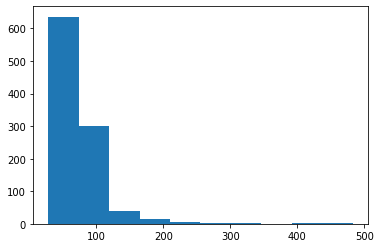

In [100]:
plt.hist(sigma2hats[:,0,0]*110**2)
plt.show()

ok, so with ~1000 loci we don't want to have to wait to estimate all the dispersal rates, so lets do this via snakemake too

In [101]:
1000*2/60

33.333333333333336

In [102]:
file = '../data/T2T_Athaliana_66.Chr4.nomissing.nohet.justSNPs_haploid_polarized_masked_100000Ne_7e-9m_popsize_10numiter_0.5threshold_3947-4001bps_1000nsamples_sigma2hats.npy'
sigmas = np.load(file)

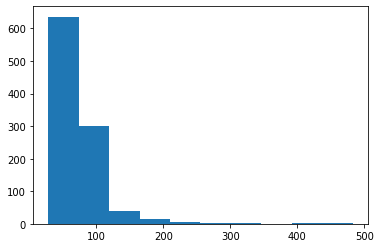

In [103]:
plt.hist(sigma2hats[:,0,0]*110**2)
plt.show()

this gives us a quick way to get the genome-wide BLUP estimate

In [104]:
t0 = time.time()
sigma_blup = np.zeros((2,2))
n = 0
string = '../data/T2T_Athaliana_66.Chr*.nomissing.nohet.justSNPs_haploid_polarized_masked_%dNe_%sm_popsize_%dnumiter_%.1fthreshold'%(Ne,m,numiter,threshold) + '_*bps_%dnsamples_sigma2hats.npy'%nsamples
for fn in glob.iglob(string):
    sigmas = np.load(fn)
    sigma_blup += np.mean(sigmas, axis=0)
    n += 1
sigma_blup = sigma_blup/n
time.time()-t0

TypeError: %d format: a number is required, not range

In [ ]:
sigma_blup

In [ ]:
mles_to_km2(sigma_blup,meanlon)[0]

we can use a similar approach to get the exact (composite) MLE with a single tree at each locus

In [ ]:
t0 = time.time()
sigma_mles = np.zeros((1000,2,2))
string = '../data/T2T_Athaliana_66.Chr*.nomissing.nohet.justSNPs_haploid_polarized_masked_%dNe_%sm_popsize_%dnumiter_%.1fthreshold'%(Ne,m,numiter,threshold) + '_*bps_%dnsamples_sigma2hats.npy'%nsamples
for fn in glob.iglob(string):
    sigmas = np.load(fn)
    sigma_mles += sigmas
sigma_mles = sigma_mles/1000 #exact mle with a single tree at each locus, for all 1000 samples of the trees
time.time()-t0

In [ ]:
plt.hist(np.log10(sigma_mles[:,0,0] * 110**2))
plt.show()

In [ ]:
np.mean(sigma_mles, axis=0)[0,0]*110**2

and now the harder thing of numerically finding the (composite) mle. first with a single tree at each locus (so we can compare to the truth, above)

to run the numerical search over 100s of loci and 1000 trees per locus we go to snakemake

# final results

Greatly improved the code above and ran on the cluster. The results are

In [ ]:
fname = '../data/T2T_Athaliana_66.nomissing.nohet.justSNPs_haploid_polarized_masked_%dNe_%sm_popsize_%dnumiter_%.1fthreshold'
fname = fname %(Ne, m, numiter, threshold) + '_1000nsamples_%stCutoff_mle-dispersal.npy'

In [ ]:
tCutoffs = ['None',int(1e6),int(1e5),int(1e4)]

In [ ]:
mles = []
for T in tCutoffs:
    mle = np.load(fname %T, allow_pickle=True)
    mles.append(mle[None][0].x)

In [ ]:
meanlon = 0.9720419696969694

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(range(len(mles)), [mle[0]**2 * 110**2 for mle in mles], label='longitude')
ax.scatter(range(len(mles)), [mle[1]**2 * (np.cos(meanlon * np.pi/180)*111)**2 for mle in mles], label='latitude')

xticks = range(len(mles))
xlabels = ['None', '$10^6$', '$10^5$', '$10^4$']
plt.xticks(xticks, xlabels)
plt.xlabel('time cutoff (generations)')

ax.set_ylim(ymin=0)
ax.set_ylabel(r'dispersal rate ($\mathrm{km}^2/\mathrm{generation}$)')
ax.legend()
    
plt.show()